##### Load Libraries

In [1]:
from yahooquery import Ticker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas_datareader.data import get_data_fred
import logging
logging.getLogger("yahooquery").setLevel(logging.CRITICAL + 1)
logging.getLogger("charset_normalizer").setLevel(logging.CRITICAL + 1)
logging.getLogger("yfinance").setLevel(logging.CRITICAL + 1)
logging.getLogger("peewee").setLevel(logging.CRITICAL + 1)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
from etfpy import get_available_etfs_list
import json
import yfinance as yf
import cvxpy as cp
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_row',None)

##### Load GDP

In [2]:
# Fetch GDP data
gdp_data = get_data_fred("GDP", start=datetime.datetime(1980, 3, 1), end=datetime.date.today())

# Convert to DataFrame
gdp_data_df = pd.DataFrame(gdp_data)
# Subtract one day from the index
gdp_data_df.index = gdp_data_df.index - pd.Timedelta(days = 1)
# Name the index
gdp_data_df.index.name = "Date"

print(gdp_data_df.head())

                 GDP
Date                
1980-03-31  2797.352
1980-06-30  2856.483
1980-09-30  2985.557
1980-12-31  3124.206
1981-03-31  3162.532


##### Load SP500, Transform, and Correlation

In [3]:
sp500 = yf.download('^GSPC', start = datetime.datetime(1980, 3, 1), end = datetime.date.today().strftime('%Y-%m-%d'))
sp500.columns = sp500.columns.get_level_values(0)
# Resample to monthly data and select the last working day of each month
sp500_data_monthly = sp500.resample('M').last()
# Correlation with GDP
correlation_Overall = sp500_data_monthly['Close'].corr(gdp_data_df['GDP'])
print(f'the corrrelation value is {round(correlation_Overall,4)}')




[*********************100%***********************]  1 of 1 completed

the corrrelation value is 0.9476


##### Load AGG, Transform, and Correlation

In [4]:
# Download data from the earliest date available until the present date
AGG_data = yf.download('AGG', start ='2003-09-29', end = datetime.date.today().strftime('%Y-%m-%d'))
AGG_data.columns = AGG_data.columns.get_level_values(0)
# Resample the daily data to monthly data
AGG_monthly = AGG_data.resample('M').last()

# Correlation with GDP
correlation_Overall = AGG_monthly['Close'].corr(gdp_data_df['GDP']) 
print(f'the corrrelation value is {round(correlation_Overall,4)}')

[*********************100%***********************]  1 of 1 completed

the corrrelation value is 0.842


#### Recession Period

In [5]:
gdp_data_df['Economic Growth'] = ((gdp_data_df['GDP'] - gdp_data_df['GDP'].shift(1)) / gdp_data_df['GDP'].shift(1)) * 100

# Identify growth periods based on three conditions
# 1. Two consecutive positive Economic Growth
# 2. Current value >= 0 and previous value <= 0, and the next value > 0
# 3. Current value < 0 and previous value >= 0, and the next value > 0

condition_1 = (gdp_data_df['Economic Growth'] >= 0) & (gdp_data_df['Economic Growth'].shift(1) >= 0)
condition_2 = (gdp_data_df['Economic Growth'] >= 0) & (gdp_data_df['Economic Growth'].shift(1) <= 0) & (gdp_data_df['Economic Growth'].shift(-1) > 0)
condition_3 = (gdp_data_df['Economic Growth'] <= 0) & (gdp_data_df['Economic Growth'].shift(1) >= 0) & (gdp_data_df['Economic Growth'].shift(-1) > 0)

growth_periods = gdp_data_df[condition_1 | condition_2 | condition_3].index.tolist()

# Identify recession periods
recession_periods = gdp_data_df[~gdp_data_df.index.isin(growth_periods)].dropna().index.tolist()

recession_start_end_dates = {}

# Initialize a variable to keep track of the current end date
current_end_date = None
for start_date in recession_periods:
    # Find the next growth date after the recession start date
    for end_date in growth_periods:
        if end_date > start_date:
            # Check if the current end date is the same as the new end date
            if current_end_date != end_date:
                recession_start_end_dates[start_date] = end_date
                current_end_date = end_date
            break
# Create a DataFrame from the recession_start_end_dates dictionary
recession_start_end = pd.DataFrame(recession_start_end_dates.items(), columns=['Recession Start', 'Recession End'])
# Calculate the duration in months and create a new column
recession_start_end['Duration(Days)'] = ((recession_start_end['Recession End'] - recession_start_end['Recession Start'])).dt.days #/ pd.Timedelta(days=1)).astype(int) / 30

recession_start_end

,Recession Start,Recession End,Duration(Days)
0,1980-06-30,1980-09-30,92
1,2008-09-30,2009-06-30,273
2,2019-12-31,2020-06-30,182


###### Beta coefficient function

In [6]:
def calculate_beta(returns_individual_stock, returns_market):
    if len(returns_individual_stock) != len(returns_market):
        raise ValueError("Input arrays must have the same length")

    covariance = np.cov(returns_individual_stock, returns_market)[0, 1]
    variance_market = np.var(returns_market)
    beta = covariance / variance_market
    return beta

###### Step 1: Import the necessary libraries and fetch ETF data from Yahooquery and ETFDatabase

In [7]:
# get_available_etfs_list() provides the list of ETF symbols from ETFDatabase
etfs_list = get_available_etfs_list()

# Initialize an empty list to store ETF information
etf_data = []

# Function to convert dictionary to DataFrame
def dict_to_dataframe(data):
    if isinstance(data, dict):
        if all(isinstance(val, (int, float, str)) for val in data.values()):
            return pd.DataFrame([data])  
        else:
            return pd.DataFrame(data).T  
    return data

# Loop through each ETF and load its information
for etf_symbol in etfs_list[:10]:
    etf = Ticker(etf_symbol)
    try:
        etf_info = {
            "history": dict_to_dataframe(etf.history()),
            "summary_detail": dict_to_dataframe(etf.summary_detail),
            "asset_profile": dict_to_dataframe(etf.asset_profile),
            "quote_type": dict_to_dataframe(etf.quote_type),
            "quotes": dict_to_dataframe(etf.quotes),
            "fund_holding_info": dict_to_dataframe(etf.fund_holding_info),
            "fund_top_holdings": dict_to_dataframe(etf.fund_top_holdings),
            "key_stats": dict_to_dataframe(etf.key_stats),
            "summary_profile": dict_to_dataframe(etf.summary_profile),
            "symbol": etf_symbol
        }
        
        etf_data.append(etf_info) 
        
    except Exception as e:
        print(f"Failed to get data for {etf_symbol}: {e}")

##### Extract the fullname and region of etf in the database

In [8]:
# Step 1: Collect long names and regions in dictionaries with etf_symbol as the key
long_names = {}
regions = {}

for etf in etf_data:
    # Access the ETF symbol
    etf_symbol = etf.get("symbol")
    
    # Access the quotes info for the ETF
    quotes_info = etf.get("quotes")
    
    # Ensure quotes_info is available and is a DataFrame
    if isinstance(quotes_info, pd.DataFrame):
        # Extract longName and region if available
        long_name = quotes_info["longName"].iloc[0] if "longName" in quotes_info.columns else None
        region = quotes_info["region"].iloc[0] if "region" in quotes_info.columns else None
        
        # Store the long name and region with etf_symbol as the key
        if long_name:
            long_names[etf_symbol] = long_name
        if region:
            regions[etf_symbol] = region

# Output the unique long names and regions dictionaries
print("Dictionary of ETF tickers and long names:", long_names)
print("Dictionary of ETF tickers and regions:", regions)

Dictionary of ETF tickers and long names: {'SPY': 'SPDR S&P 500 ETF', 'IVV': 'iShares Core S&P 500 ETF', 'VOO': 'Vanguard S&P 500 ETF', 'VTI': 'Vanguard Total Stock Market Index Fund ETF Shares', 'QQQ': 'Invesco QQQ Trust', 'VEA': 'Vanguard FTSE Developed Markets Index Fund ETF Shares', 'VTV': 'Vanguard Value Index Fund ETF Shares', 'IEFA': 'iShares Core MSCI EAFE ETF', 'BND': 'Vanguard Total Bond Market Index Fund', 'AGG': 'iShares Core U.S. Aggregate Bond ETF'}
Dictionary of ETF tickers and regions: {'SPY': 'US', 'IVV': 'US', 'VOO': 'US', 'VTI': 'US', 'QQQ': 'US', 'VEA': 'US', 'VTV': 'US', 'IEFA': 'US', 'BND': 'US', 'AGG': 'US'}


In [23]:
# Function to find ETF data by ticker symbol
def get_etf_data_by_symbol(symbol):
    for etf in etf_data:
        if etf['symbol'] == symbol:
            return etf
    return None 

data = get_etf_data_by_symbol('SPY')["fund_holding_info"]
data

,maxAge,cashPosition,stockPosition,bondPosition,otherPosition,preferredPosition,convertiblePosition,holdings,equityHoldings,bondHoldings,bondRatings,sectorWeightings
SPY,1,0.0013,0.9987,0.0,0.0,0.0,0.0,"[{'symbol': 'NVDA', 'holdingName': 'NVIDIA Cor...","{'priceToEarnings': 0.03672, 'priceToBook': 0....",{},[{'us_government': 0.0}],"[{'realestate': 0.02}, {'consumer_cyclical': 0..."


###### Step 2: Classify ETFs into stock, bond, and others AND Build and save in  the final JSON file

In [11]:
# Initialize lists to store classified ETFs with quotes and key statistics info
bond_etfs = []
stock_etfs = []
other_etfs = []

# Define the required columns for the fund_holding_info DataFrame
required_columns = ['bondPosition', 'bondHoldings', 'bondRatings', 'cashPosition', 'sectorWeightings', 'stockPosition']

# Loop through each ETF's data in the etf_data list
for etf_info in etf_data:
    symbol = etf_info.get("symbol")
    
    # Access the 'fund_holding_info' DataFrame
    fund_holding_info_df = etf_info.get("fund_holding_info")
    
    if isinstance(fund_holding_info_df, pd.DataFrame):
        for col in required_columns:
            if col not in fund_holding_info_df.columns:
                fund_holding_info_df[col] = 0.0  

        filtered_df = fund_holding_info_df[required_columns].copy()

        # Calculate the sum of bondPosition and cashPosition
        bond_cash_sum = filtered_df['bondPosition'].sum() + filtered_df['cashPosition'].sum()
        
        # Access the quotes info for the ETF
        quotes_info = etf_info.get("quotes")
        
        # Ensure quotes_info is available and is a DataFrame
        if isinstance(quotes_info, pd.DataFrame):
            filtered_quotes = {
                "netExpenseRatio": quotes_info["netExpenseRatio"].iloc[0] if "netExpenseRatio" in quotes_info.columns else None,
                "region": quotes_info["region"].iloc[0] if "region" in quotes_info.columns else None,
                "longName": quotes_info["longName"].iloc[0] if "longName" in quotes_info.columns else None,
                "shortName": quotes_info["shortName"].iloc[0] if "shortName" in quotes_info.columns else None }
        else:
            print(f"Quotes data not available for {symbol}.")
            filtered_quotes = {} 
        
        # Access the key statistics info for the ETF
        statistics_info = etf_info.get("key_stats")
        
        # Ensure statistics_info is available and is a DataFrame
        if isinstance(statistics_info, pd.DataFrame):
            filtered_stats = {
                "beta3Year": statistics_info["beta3Year"].iloc[0] if "beta3Year" in statistics_info.columns else None,
                "fundInceptionDate": statistics_info["fundInceptionDate"].iloc[0] if "fundInceptionDate" in statistics_info.columns else None,
                "totalAssets": statistics_info["totalAssets"].iloc[0] if "totalAssets" in statistics_info.columns else None,
                "category": statistics_info["category"].iloc[0] if "category" in statistics_info.columns else None }
        else:
            print(f"Key statistics not available for {symbol}.")
            filtered_stats = {}

        # Classify ETFs as bond ETFs if bond_cash_sum >= 0.95
        if bond_cash_sum >= 0.95:
            bond_etfs.append({
                "symbol": symbol,
                "fund_holding_info": filtered_df.to_dict(),
                "quotes": filtered_quotes,
                "key_stats": filtered_stats })

        # Classify ETFs as stock ETFs if stockPosition >= 0.85
        elif filtered_df['stockPosition'].sum() >= 0.85:
            stock_etfs.append({
                "symbol": symbol,
                "fund_holding_info": filtered_df.to_dict(),
                "quotes": filtered_quotes,
                "key_stats": filtered_stats })

        # Classify ETFs as "Others" if they don't fit the above categories
        else:
            other_etfs.append({
                "symbol": symbol,
                "fund_holding_info": filtered_df.to_dict(),
                "quotes": filtered_quotes,
                "key_stats": filtered_stats })

    else:
        print(f"No fund holding info data available for {symbol}.")

# Organize the data into a dictionary
etf_classified_data = {
    "bond_etfs": bond_etfs,
    "stock_etfs": stock_etfs,
    "other_etfs": other_etfs}

# Save the data to a JSON file
with open('classified_etfs.json', 'w') as json_file:
    json.dump(etf_classified_data, json_file, indent = 4)


##### Excel sheet for the breakdowns 

In [14]:
# Create lists to store formatted data for the Excel sheet
stock_sector_data = []  
bond_details_data = []  

# Process stock ETFs to extract sector weightings
for stock_etf in stock_etfs:
    symbol = stock_etf["symbol"]
    fund_holding_info = stock_etf["fund_holding_info"]
    
    # Extract sector weightings and handle the structure
    sector_weightings = fund_holding_info.get("sectorWeightings", {})
    cash_position = fund_holding_info.get("cashPosition", 0)
    
    # Initialize sector data
    sector_data = {"Ticker Name": symbol}
    
    # Check if sectorWeightings is a dictionary with the ETF symbol as the key
    if isinstance(sector_weightings, dict) and symbol in sector_weightings:
        sector_list = sector_weightings[symbol]  
        if isinstance(sector_list, list):
            for i, sector in enumerate(sector_list):
                # Ensure each sector entry is a dictionary
                if isinstance(sector, dict):
                    sector_name, weight = list(sector.items())[0]  # Extract sector name and weight
                    sector_data[f"{sector_name.capitalize()} (Sector {i+1})"] = weight
                else:
                    print(f"Unexpected format in sectorWeightings for {symbol}: {sector}")
    else:
        print(f"Unexpected format for sectorWeightings in {symbol}: {sector_weightings}")
    
    sector_data["Other|Cash Position"] = cash_position if isinstance(cash_position, (int, float)) else 0
    sector_data["TOTAL"] = sum(
        value for key, value in sector_data.items() if isinstance(value, (int, float))
    )  # Only sum numeric values
    stock_sector_data.append(sector_data)

# Iterate through the bond ETFs
for bond_etf in bond_etfs:
    symbol = bond_etf["symbol"]
    fund_holding_info = bond_etf.get("fund_holding_info", {})

    # Safely extract cash position
    cash_position = fund_holding_info.get("cashPosition", {}).get("value", 0)

    # Initialize a row dictionary with general columns
    bond_data = {
        "Ticker Name": symbol,
        "Cash Position": cash_position,
    }

    # Process bond ratings
    bond_ratings = fund_holding_info.get("bondRatings", {}).get(symbol, [])
    total_bond_position = cash_position  # Initialize total bond position with cash

    for rating_dict in bond_ratings:
        if isinstance(rating_dict, dict):  # Ensure it's a dictionary
            for rating_type, value in rating_dict.items():
                # Add rating type as a column, ensure consistent naming
                rating_column = rating_type.upper()  # Uppercase for column names
                bond_data[rating_column] = value
                total_bond_position += value  # Sum bond ratings into total bond position

    # Add the total bond position to the row
    bond_data["TOTAL Bond Position"] = total_bond_position

    # Append the processed data
    bond_details_data.append(bond_data)
    
# Convert lists to DataFrames for writing to Excel
stock_sector_df = pd.DataFrame(stock_sector_data)
bond_details_df = pd.DataFrame(bond_details_data)

# Fill missing values with 0
bond_details_df.fillna(0, inplace=True)

# Write to Excel
with pd.ExcelWriter("ETF_Details.xlsx", engine="xlsxwriter") as writer:
    # Write stock ETF sector weightings to the first sheet
    stock_sector_df.to_excel(writer, sheet_name="Stock Sector Weightings", index=False)
    
    # Write bond ETF details to the second sheet
    bond_details_df.to_excel(writer, sheet_name="Bond Details", index=False)

print("Excel file 'ETF_Details.xlsx' created successfully!")

Excel file 'ETF_Details.xlsx' created successfully!


In [17]:
# Load the Excel file
excel_file = 'ETF_Details.xlsx'

# Read each sheet separately
stock_sector_weightings = pd.read_excel(excel_file, sheet_name = 'Stock Sector Weightings')
bond_details = pd.read_excel(excel_file, sheet_name = 'Bond Details')

# Safely drop the 'TOTAL' column if it exists
if 'TOTAL' in stock_sector_weightings.columns:
    stock_sector_weightings = stock_sector_weightings.drop(columns = ['TOTAL'], axis = 1)
if 'TOTAL' in bond_details.columns:
    bond_details = bond_details.drop(columns = ['TOTAL Bond Position'], axis = 1)

In [18]:
# Clustering rules for STOCKS
clusters_stocks = {
    "Cluster 1": lambda row: row.max() > 0.7,  # More than 70% in one sector
    "Cluster 2": lambda row: row.nlargest(2).sum() > 0.6 and row.nlargest(2).min() > 0.3,  # Two main industries
    "Cluster 3": lambda row: row.nlargest(3).sum() > 0.6 and row.nlargest(3).min() > 0.2,  # Three main industries, heavily diversified
    "Cluster 4": lambda row: True}

# Assign clusters for STOCKS
def classify_stocks(row):
    numeric_row = pd.to_numeric(row.iloc[1:], errors = 'coerce')  
    for cluster, condition in clusters_stocks.items():
        if condition(numeric_row):  
            return cluster
    return "Unclassified"
# Apply classification to Stock Sector Weightings
stock_sector_weightings['Stock_Cluster'] = stock_sector_weightings.apply(classify_stocks, axis = 1)


# Clustering rules for BONDS
clusters_bonds = {
    "Cluster 1": lambda row: row[['AA', 'AAA', 'A']].sum() > 0.8,
    "Cluster 2": lambda row: row[['BBB']].sum() > 0.9,
    "Cluster 3": lambda row: True}

# Assign clusters for BONDS
def classify_bonds(row):
    numeric_row = pd.to_numeric(row.iloc[1:], errors = 'coerce')  
    for cluster, condition in clusters_bonds.items():
        if condition(numeric_row):  
            return cluster
    return "Unclassified"

# Apply classification to Bond Details
bond_details['Bond_Cluster'] = bond_details.apply(classify_bonds, axis = 1)

In [19]:
# Function to write clusters into separate tables in the same Excel sheet
def write_clusters_to_excel(dataframe, cluster_column_name, filename):
    """
    Writes separate tables for each cluster in a single Excel sheet.
    
    Args:
    - dataframe (pd.DataFrame): The DataFrame containing cluster data.
    - cluster_column_name (str): The name of the column with cluster labels.
    - filename (str): The name of the Excel file to save the clusters.
    """
    with pd.ExcelWriter(filename, engine = 'openpyxl') as writer:
        start_row = 0  # Initialize starting row for the first cluster

        # Get unique clusters
        clusters = dataframe[cluster_column_name].unique()
        for cluster in clusters:
            # Filter rows for the current cluster
            cluster_data = dataframe[dataframe[cluster_column_name] == cluster]

            # Write a title for the cluster table
            cluster_title = pd.DataFrame({f"Cluster: {cluster}": []})  
            cluster_title.to_excel(
                writer,
                sheet_name = "Clusters",
                startrow=start_row,
                index=False,
                header=False,
            )
            start_row += 1  # Increment row for cluster data

            # Write the actual cluster data
            cluster_data.to_excel(
                writer,
                sheet_name = "Clusters",
                startrow = start_row,
                index = False,
                header = True,
            )
            start_row += len(cluster_data) + 2 

    print(f"Clusters have been successfully written to {filename}!")

# Apply the function to bond and stock datasets
write_clusters_to_excel(
    dataframe=bond_details, 
    cluster_column_name="Bond_Cluster", 
    filename="Bond_Clusters.xlsx")

write_clusters_to_excel(
    dataframe = stock_sector_weightings, 
    cluster_column_name = "Stock_Cluster", 
    filename = "Stock_Sector_Clusters.xlsx")

Clusters have been successfully written to Bond_Clusters.xlsx!
Clusters have been successfully written to Stock_Sector_Clusters.xlsx!


###### Filter the Bond category and load the history for the ETFS that pass the fitration

In [20]:
# Load the data from the JSON file
with open('classified_etfs.json', 'r') as json_file:
    etf_classified_data = json.load(json_file)

# Check if bond_etfs data is present
if 'bond_etfs' in etf_classified_data:
    bond_etfs = etf_classified_data['bond_etfs']
    
    # Convert the bond ETF data into a DataFrame for filtering
    bond_etf_list = []
    for etf in bond_etfs:
        # Extract bondHoldings data from fund_holding_info
        bond_holdings = etf['fund_holding_info'].get('bondHoldings', {})
        
        # Initialize a variable to store duration
        duration = None
        
        # Loop through bondHoldings to extract the duration (assuming there could be multiple bonds)
        for bond_ticker, bond_data in bond_holdings.items():
            if 'duration' in bond_data:
                duration = bond_data['duration']
                break  

        # Append each ETF's data into the bond_etf_list
        bond_etf_list.append({
            "Symbol": etf['symbol'],
            "duration": duration,  
            "totalAssets": etf['key_stats'].get('totalAssets', 0),
            "fundInceptionDate": etf['key_stats'].get('fundInceptionDate', 'N/A'),
            "netExpenseRatio": etf['quotes'].get('netExpenseRatio', 0),
            "region": etf['quotes'].get('region', 'N/A') })
    
    # Create a DataFrame from the bond ETF list
    etf_df_bond = pd.DataFrame(bond_etf_list)

    # Convert the 'fundInceptionDate' column to datetime for filtering
    etf_df_bond['fundInceptionDate'] = pd.to_datetime(etf_df_bond['fundInceptionDate'], errors='coerce')

    # Apply the filtering logic
    filtered_data = etf_df_bond[
        (etf_df_bond['duration'] >= 3.47) &   
        (etf_df_bond['totalAssets'] >= 1000000) & 
        (etf_df_bond['fundInceptionDate'] <= '2017-01-01') &  
        (etf_df_bond['netExpenseRatio'] <= 0.1) &  
        etf_df_bond['region'].str.contains('US', na=False) ].reset_index(drop=True)

    # Extract the filtered ETF tickers
    etf_tickers = filtered_data['Symbol']

    # Create a dictionary to store ETF data from Yahoo Finance
    etf_data_bond = {}

    # Loop through the ETF tickers and download data from Yahoo Finance
    for etf_ticker in etf_tickers:
        try:
            etf_data_bond[etf_ticker] = yf.download(etf_ticker, start='2000-01-01', end = datetime.date.today().strftime('%Y-%m-%d'))
        except Exception as e:
            print(f"Failed to download data for {etf_ticker}: {e}")
else:
    print("No bond ETFs found in the data.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


##### Each Filtered bond etfs Correlation with AGG

In [ ]:
bond_etf_correlation = []

for ticker, data in etf_data_bond.items():
    # Flatten MultiIndex columns if necessary
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)  # Keep only first level

    # Now 'Close' is accessible
    correlation = data['Close'].corr(AGG_data['Close'])
    
    bond_etf_correlation.append({
        "ETF Ticker": ticker,
        "Correlation with AGG": correlation })

# Convert to DataFrame
bond_etf_correlation_overall_df = pd.DataFrame(bond_etf_correlation).sort_values(
    by="Correlation with AGG", ascending=False)

# Reset the index
bond_etf_correlation_overall_df.reset_index(drop=True, inplace=True)

bond_etf_correlation_overall_df


,ETF Ticker,Correlation with AGG
0,AGG,1.000000
1,BND,0.999707


##### Each Filtered Bond etfs Coefficient Beta with AGG

In [25]:
bond_etf_beta_coefficient = []

# Define the start and end dates based on the AGG data
agg_start_date = AGG_data.index.min()
agg_end_date = AGG_data.index.max()

for selected_etf_ticker in etf_tickers:
    # Extract the DataFrame for the selected ETF
    selected_etf_data = etf_data_bond[selected_etf_ticker]

    # Define the start and end dates based on the ETF data
    start_date = selected_etf_data.index.min()
    end_date = selected_etf_data.index.max()

    # Check if ETF start date is earlier than AGG start date
    if start_date < agg_start_date:
        start_date = agg_start_date

    # Check if ETF end date is later than AGG end date
    if end_date > agg_end_date:
        end_date = agg_end_date

    # Filter the ETF data to match the date range
    selected_etf_data_range = selected_etf_data[(selected_etf_data.index >= start_date) & (selected_etf_data.index <= end_date)]['Close'].pct_change().dropna()
    AGG_selected = AGG_data[(AGG_data.index >= start_date) & (AGG_data.index <= end_date)]['Close'].pct_change().dropna()

    # Calculate beta using the common date range
    beta = calculate_beta(selected_etf_data_range, AGG_selected)

    bond_etf_beta_coefficient.append({"ETF Ticker": selected_etf_ticker, "beta": round(beta, 3)})

bond_etf_beta_overall_df = pd.DataFrame(bond_etf_beta_coefficient).sort_values(by='beta', ascending=False)

# Reset the index and save the DataFrame to a CSV file
bond_etf_beta_overall_df.reset_index(drop=True, inplace=True)

bond_etf_beta_overall_df

,ETF Ticker,beta
0,AGG,1.000
1,BND,0.835


##### Bond etfs correlation during recession & the median 

In [27]:
# Initialize an empty list to store correlation results
bond_etf_correlation_recession = []

# Iterate through each ETF and each recession period
for etf_ticker in etf_tickers:
    for start_date, end_date in recession_start_end_dates.items():
        # Extract the DataFrame for the selected ETF
        selected_etf_data = etf_data_bond[etf_ticker]

        # Define the start and end dates based on the ETF data
        start_date_etf = selected_etf_data.index.min()
        end_date_etf = selected_etf_data.index.max()

        # Check if ETF start date is earlier than AGG start date or ETF end date is later than AGG end date
        if start_date_etf < agg_start_date:
            start_date_etf = agg_start_date
        if end_date_etf > agg_end_date:
            end_date_etf = agg_end_date

        # Check if the ETF data falls within the current recession period
        if start_date_etf <= end_date and end_date_etf >= start_date:
            # Filter the ETF data to match the date range within the recession period
            selected_etf_data_range = selected_etf_data[
                (selected_etf_data.index >= max(start_date, start_date_etf)) &
                (selected_etf_data.index <= min(end_date, end_date_etf))
            ]['Close'].pct_change().dropna()

            # Filter AGG data to match the same date range
            AGG_selected = AGG_data[
                (AGG_data.index >= max(start_date, start_date_etf)) &
                (AGG_data.index <= min(end_date, end_date_etf))
            ]['Close'].pct_change().dropna()

            # Calculate the correlation using the common date range
            correlation_bond_etf = selected_etf_data_range.corr(AGG_selected)

            bond_etf_correlation_recession.append({
                "ETF Ticker": etf_ticker,
                "Recession Start": start_date,
                "Recession End": end_date,
                "Correlation": round(correlation_bond_etf, 3)
            })

# Create a DataFrame from the results
bond_etf_recession_correlation_df = pd.DataFrame(bond_etf_correlation_recession)

# Calculate median beta during the recession for each ETF
bond_etf_recession_correlation_median = bond_etf_recession_correlation_df.groupby("ETF Ticker")["Correlation"].median().reset_index()
bond_etf_recession_correlation_median = bond_etf_recession_correlation_median.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

# Print the median beta results
print(bond_etf_recession_correlation_median)

  ETF Ticker  Correlation
0        AGG       1.0000
1        BND       0.7565


##### Bond etfs Coefficient beta during recession  

In [29]:
# Initialize an empty list to store beta results
bond_etf_recession_beta = []

# Iterate through each ETF and each recession period
for etf_ticker in etf_tickers:
    for start_date, end_date in recession_start_end_dates.items():
        # Extract the DataFrame for the selected ETF
        selected_etf_data = etf_data_bond[etf_ticker]

        # Define the start and end dates based on the ETF data
        start_date_etf = selected_etf_data.index.min()
        end_date_etf = selected_etf_data.index.max()

        # Check if ETF start date is earlier than AGG start date or ETF end date is later than AGG end date
        if start_date_etf < agg_start_date:
            start_date_etf = agg_start_date
        if end_date_etf > agg_end_date:
            end_date_etf = agg_end_date

        # Check if the ETF data falls within the current recession period
        if start_date_etf <= end_date and end_date_etf >= start_date:
            # Filter the ETF data to match the date range within the recession period
            selected_etf_data_range = selected_etf_data[
                (selected_etf_data.index >= max(start_date, start_date_etf)) &
                (selected_etf_data.index <= min(end_date, end_date_etf))
            ]['Close'].pct_change().dropna()

            # Filter AGG data to match the same date range
            AGG_selected = AGG_data[
                (AGG_data.index >= max(start_date, start_date_etf)) &
                (AGG_data.index <= min(end_date, end_date_etf))
            ]['Close'].pct_change().dropna()

            # Calculate beta using the common date range
            beta_recession_bond_etf = calculate_beta(selected_etf_data_range, AGG_selected)

            bond_etf_recession_beta.append({
                "ETF Ticker": etf_ticker,
                "Recession Start": start_date,
                "Recession End": end_date,
                "Beta": round( beta_recession_bond_etf, 3)
            })

# Create a DataFrame from the results
bond_etf_recession_beta_df = pd.DataFrame(bond_etf_recession_beta)

# Calculate median beta during the recession for each ETF
bond_etf_recession_beta_median = bond_etf_recession_beta_df.groupby("ETF Ticker")["Beta"].median().reset_index()
bond_etf_recession_beta_median = bond_etf_recession_beta_median.sort_values(by='Beta', ascending=False).reset_index(drop=True)

# Print the median beta results
print(bond_etf_recession_beta_median)

  ETF Ticker    Beta
0        AGG  1.0065
1        BND  0.7345


##### Bond etf correlation during growth 

In [30]:
# Initialize an empty list to store correlation results
bond_etf_growth_correlation = []

# Iterate through each ETF and each recession period
for etf_ticker in etf_tickers:
    # Extract the DataFrame for the selected ETF
    selected_etf_data = etf_data_bond[etf_ticker]

    # Define the start and end dates based on the ETF data
    start_date_etf = selected_etf_data.index.min()
    end_date_etf = selected_etf_data.index.max()

    # Initialize variables
    last_recession_start = None

    # Iterate through each growth period date
    for date in growth_periods:
        # Find the next recession start date after the growth date
        next_recession_start = None
        for start_date, end_date in recession_start_end_dates.items():
            if start_date > date:
                next_recession_start = start_date
                break

        # Check if this is the last growth period after the last recession
        if next_recession_start is None:
            next_recession_start = gdp_data_df.index.max()  

        # If the next recession start is different from the last one, calculate the correlation
        if next_recession_start != last_recession_start:
            # Find the growth end date (start of a new recession minus three months)
            growth_end_date = next_recession_start - pd.DateOffset(months = 3)

            # Check if the ETF data falls within the current growth period
            if start_date_etf <= growth_end_date and end_date_etf >= date:
                # Filter the ETF data to match the date range within the growth period
                selected_etf_data_range = selected_etf_data[
                    (selected_etf_data.index >= max(date, start_date_etf)) &
                    (selected_etf_data.index <= min(growth_end_date, end_date_etf))
                ]['Close'].pct_change().dropna()

                # Filter AGG data to match the same date range
                AGG_selected = AGG_data[
                    (AGG_data.index >= max(date, start_date_etf)) &
                    (AGG_data.index <= min(growth_end_date, end_date_etf))
                ]['Close'].pct_change().dropna()

                # Calculate the correlation using the common date range
                bond_etf_correlation = selected_etf_data_range.corr(AGG_selected)

                bond_etf_growth_correlation.append({
                    "ETF Ticker": etf_ticker,
                    "Growth Start": date,
                    "Growth End": growth_end_date,
                    "Correlation": round(bond_etf_correlation, 3)
                })

            # Update the last recession start date
            last_recession_start = next_recession_start

# Create a DataFrame from the results
bond_etf_growth_correlation_df = pd.DataFrame(bond_etf_growth_correlation).dropna().reset_index(drop=True)

# Calculate median beta during the recession for each ETF
bond_etf_growth_correlation_median  = bond_etf_growth_correlation_df.groupby("ETF Ticker")["Correlation"].median().reset_index()
bond_etf_growth_correlation_median  = bond_etf_growth_correlation_median.sort_values(by = 'Correlation', ascending=False).reset_index(drop=True)

# Print the median beta results
print(bond_etf_growth_correlation_median)

  ETF Ticker  Correlation
0        AGG        1.000
1        BND        0.934


##### Bond etf Coeficient beta during growth

In [31]:
# Initialize an empty list to store beta results
bond_etf_growth_beta = []

# Iterate through each ETF and each recession period
for etf_ticker in etf_tickers:
    # Extract the DataFrame for the selected ETF
    selected_etf_data = etf_data_bond[etf_ticker]

    # Define the start and end dates based on the ETF data
    start_date_etf = selected_etf_data.index.min()
    end_date_etf = selected_etf_data.index.max()

    # Initialize variables
    last_recession_start = None

    # Iterate through each growth period date
    for date in growth_periods:
        # Find the next recession start date after the growth date
        next_recession_start = None
        for start_date, end_date in recession_start_end_dates.items():
            if start_date > date:
                next_recession_start = start_date
                break

        # Check if this is the last growth period after the last recession
        if next_recession_start is None:
            next_recession_start = gdp_data_df.index.max()  # Use the end of the dataset as the end

        # If the next recession start is different from the last one, calculate the beta
        if next_recession_start != last_recession_start:
            # Find the growth end date (start of a new recession minus three months)
            growth_end_date = next_recession_start - pd.DateOffset(months = 3)

            # Check if the ETF data falls within the current growth period
            if start_date_etf <= growth_end_date and end_date_etf >= date:
                # Filter the ETF data to match the date range within the growth period
                selected_etf_data_range = selected_etf_data[
                    (selected_etf_data.index >= max(date, start_date_etf)) &
                    (selected_etf_data.index <= min(growth_end_date, end_date_etf))
                ]['Close'].pct_change().dropna()

                # Find AGG start and end dates aligned with the ETF
                AGG_selected = AGG_data[
                    (AGG_data.index >= selected_etf_data_range.index.min()) &
                    (AGG_data.index <= selected_etf_data_range.index.max())
                ]['Close'].pct_change().dropna()

                # Ensure both data series have the same length
                min_length = min(len(selected_etf_data_range), len(AGG_selected))
                selected_etf_data_range = selected_etf_data_range[-min_length:]
                AGG_selected = AGG_selected[-min_length:]

                # Calculate beta using the common date range
                bond_etf_beta = calculate_beta(selected_etf_data_range, AGG_selected)

                bond_etf_growth_beta.append({
                    "ETF Ticker": etf_ticker,
                    "Growth Start": date,
                    "Growth End": growth_end_date,
                    "Beta": round(bond_etf_beta, 3)
                })

            # Update the last recession start date
            last_recession_start = next_recession_start

# Create a DataFrame from the results
bond_etf_growth_beta_df = pd.DataFrame(bond_etf_growth_beta).dropna().reset_index(drop=True)

# Calculate median beta during the recession for each ETF
bond_etf_growth_beta_median = bond_etf_growth_beta_df.groupby("ETF Ticker")["Beta"].median().reset_index().sort_values(by='Beta', ascending = False).reset_index(drop=True)
bond_etf_growth_beta_median = bond_etf_growth_beta_median.sort_values(by='Beta', ascending = False).reset_index(drop=True)

# Print the median beta results
print(bond_etf_growth_beta_median) 

  ETF Ticker   Beta
0        AGG  1.001
1        BND  0.934


##### Bond Eft classification

In [32]:
# Sample data for demonstration purposes
bond_etf_growth_beta_median_dict = bond_etf_growth_beta_median.set_index('ETF Ticker')['Beta'].to_dict()  
bond_etf_recession_beta_median_dict = bond_etf_recession_beta_median.set_index('ETF Ticker')['Beta'].to_dict() 

# Create empty lists to categorize ETFs
faster_growth_bond_etf = []
slower_growth_bond_etf = []
faster_recession_bond_etf = []
slower_recession_bond_etf = []

for ticker, data in etf_data_bond.items():
    # Retrieve beta values for the current ETF
    beta_growth_bond_etf = bond_etf_growth_beta_median_dict .get(ticker)  
    beta_recession_bond_etf = bond_etf_recession_beta_median_dict.get(ticker)  
    
    if beta_growth_bond_etf is not None and beta_recession_bond_etf is not None:
        # Categorize ETFs based on beta values
        if beta_growth_bond_etf >= 1:
            faster_growth_bond_etf.append(ticker)
        else:
            slower_growth_bond_etf.append(ticker)
        
        if beta_recession_bond_etf >= 1:
            faster_recession_bond_etf.append(ticker)
        else:
            slower_recession_bond_etf.append(ticker)
    else:
        # Handle missing beta values
        print(f"Beta values for ETF {ticker} are missing.")

# Print or store the categorized ETFs
print("\nBond-ETFs Faster than Market during GROWTH:", faster_growth_bond_etf)
print("\nBond-ETFs Slower than Market during GROWTH:", slower_growth_bond_etf)
print("\nBond-ETFs Faster than Market during RECESSION:", faster_recession_bond_etf)
print("\nBond-ETFs Slower than Market during RECESSION:", slower_recession_bond_etf)


Bond-ETFs Faster than Market during GROWTH: ['AGG']

Bond-ETFs Slower than Market during GROWTH: ['BND']

Bond-ETFs Faster than Market during RECESSION: ['AGG']

Bond-ETFs Slower than Market during RECESSION: ['BND']


##### Filter the Stock category and load the history for the ETFS that pass the fitration

In [33]:
# Load the data from the JSON file
with open('classified_etfs.json', 'r') as json_file:
    etf_classified_data = json.load(json_file)

# Check if bond_etfs data is present
if 'stock_etfs' in etf_classified_data:
    stock_etfs = etf_classified_data['stock_etfs']
    
    # Convert the bond ETF data into a DataFrame for filtering
    stock_etf_list = []
    for etf in stock_etfs:
        # Append each ETF's data into the bond_etf_list
        stock_etf_list.append({
            "Symbol": etf['symbol'],
            "totalAssets": etf['key_stats'].get('totalAssets', 0),
            "fundInceptionDate": etf['key_stats'].get('fundInceptionDate', 'N/A'),
            "netExpenseRatio": etf['quotes'].get('netExpenseRatio', 0),
            "region": etf['quotes'].get('region', 'N/A')
        })
    
    # Create a DataFrame from the bond ETF list
    etf_df_stock = pd.DataFrame(stock_etf_list)

    # Convert the 'fundInceptionDate' column to datetime for filtering
    etf_df_stock['fundInceptionDate'] = pd.to_datetime(etf_df_stock['fundInceptionDate'], errors='coerce')

    # Apply the filtering logic
    filtered_data = etf_df_stock[
        (etf_df_stock['totalAssets'] >= 3000000) & 
        (etf_df_stock['fundInceptionDate'] <= '2013-01-01') &  
        (etf_df_stock['netExpenseRatio'] <= 0.2) &  
        etf_df_stock['region'].str.contains('US', na=False) 
    ].reset_index(drop=True)

    # Extract the filtered ETF tickers
    etf_tickers = filtered_data['Symbol']

    # Create a dictionary to store ETF data from Yahoo Finance
    etf_data_stock = {}

    # Loop through the ETF tickers and download data from Yahoo Finance
    for etf_ticker in etf_tickers:
        try:
            etf_data_stock[etf_ticker] = yf.download(etf_ticker, start='2000-01-01', end=datetime.date.today().strftime('%Y-%m-%d'))
        except Exception as e:
            print(f"Failed to download data for {etf_ticker}: {e}")
else:
    print("No bond ETFs found in the data.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


##### Each Filtered Stock etfs Correlation with SP500

In [34]:
stock_etf_correlation = []


for ticker, data in etf_data_stock.items():
    # Flatten ETF columns if MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    # Calculate correlation with S&P 500
    correlation = data['Close'].corr(sp500['Close'])
    
    stock_etf_correlation.append({
        "ETF Ticker": ticker,
        "Correlation with SP500": correlation
    })

# Convert to DataFrame and sort
stock_etf_correlation_overall_df = pd.DataFrame(stock_etf_correlation).sort_values(
    by="Correlation with SP500", ascending=False
)

# Reset index
stock_etf_correlation_overall_df.reset_index(drop=True, inplace=True)

stock_etf_correlation_overall_df


,ETF Ticker,Correlation with SP500
0,VOO,0.999545
1,VTI,0.999147
2,IVV,0.999072
3,SPY,0.998988
4,VTV,0.994264
5,QQQ,0.992808
6,VEA,0.972380
7,IEFA,0.971026


##### Each Filtered Stock etfs coefficient Beta with SP500

In [36]:
stock_etf_beta_coefficient = [] 

# Define the start and end dates based on the sp500 data
sp500_start_date = sp500.index.min()
sp500_end_date = sp500.index.max()

for selected_etf_ticker in etf_tickers:
    # Extract the DataFrame for the selected ETF
    selected_etf_data = etf_data_stock[selected_etf_ticker]

    # Define the start and end dates based on the ETF data
    start_date = selected_etf_data.index.min()
    end_date = selected_etf_data.index.max()

    # Check if ETF start date is earlier than Sp500 start date
    if start_date < sp500_start_date:
        start_date = sp500_start_date

    # Check if ETF end date is later than Sp500 end date
    if end_date > sp500_end_date:
        end_date = sp500_end_date

    # Filter the ETF data to match the date range
    selected_etf_data_range = selected_etf_data[(selected_etf_data.index >= start_date) & (selected_etf_data.index <= end_date)]['Close'].pct_change().dropna()
    sp500_selected = sp500[(sp500.index >= start_date) & (sp500.index <= end_date)]['Close'].pct_change().dropna()

    # Calculate beta using the common date range
    stock_etf_beta = calculate_beta(selected_etf_data_range, sp500_selected)

    stock_etf_beta_coefficient.append({"ETF Ticker": selected_etf_ticker, "beta": round(stock_etf_beta, 3)})

stock_etf_beta_overall_df = pd.DataFrame(stock_etf_beta_coefficient).sort_values(by='beta', ascending=False)

# Reset the index and save the DataFrame to a CSV file
stock_etf_beta_overall_df.reset_index(drop=True, inplace=True)

stock_etf_beta_overall_df

,ETF Ticker,beta
0,QQQ,1.176
1,VOO,0.995
2,VTI,0.994
3,SPY,0.989
4,IVV,0.984
5,VEA,0.952
6,VTV,0.948
7,IEFA,0.822


###### Stock etfs correlation during recession & the median 

In [37]:
# Initialize an empty list to store correlation results
stock_etf_correlation_recession = []

# Iterate through each ETF in etf_tickers
for etf_ticker in etf_tickers:
    for start_date, end_date in recession_start_end_dates.items():
        # Subset the ETF data for the specific recession period
        etf_df_period = etf_data_stock[etf_ticker][(etf_data_stock[etf_ticker].index >= start_date) & (etf_data_stock[etf_ticker].index <= end_date)]
        
        # Filter the S&P 500 data to match the date range of the ETF
        sp500_period = sp500[(sp500.index >= start_date) & (sp500.index <= end_date)]
        
        # Check if ETF data exists for this recession period
        if etf_df_period.empty:
            continue
        
        # Check if S&P 500 data exists for this recession period
        if sp500_period.empty:
            continue

        # Calculate correlation for the ETF and S&P 500 for the current recession period
        stock_etf_correlation = etf_df_period['Close'].corr(sp500_period['Close'])

        stock_etf_correlation_recession.append({
            "ETF Ticker": etf_ticker,
            "Recession Start": start_date,
            "Recession End": end_date,
            "Correlation": round(stock_etf_correlation, 3)
        })

# Create a DataFrame from the results
stock_etf_recession_correlation_df = pd.DataFrame(stock_etf_correlation_recession)

# Calculate median correlation during recession for each ETF
stock_etf_recession_correlation_median = stock_etf_recession_correlation_df.groupby("ETF Ticker")["Correlation"].median().reset_index()
stock_etf_recession_correlation_median = stock_etf_recession_correlation_median.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

# Print the median correletion results
print(stock_etf_recession_correlation_median)

  ETF Ticker  Correlation
0        VOO       0.9990
1        IVV       0.9980
2        SPY       0.9975
3        VTI       0.9945
4        VTV       0.9705
5       IEFA       0.9670
6        VEA       0.9525
7        QQQ       0.7500


###### Stock etf Coefficient beta during recession  

In [38]:
# Initialize an empty list to store beta results
stock_etf_recession_beta = []

# Iterate through each ETF in etf_tickers
for etf_ticker in etf_tickers:
    for start_date, end_date in recession_start_end_dates.items():
        # Subset the ETF data for the specific recession period
        etf_df_period = etf_data_stock[etf_ticker][(etf_data_stock[etf_ticker].index >= start_date) & (etf_data_stock[etf_ticker].index <= end_date)]
        
        # Filter the S&P 500 data to match the date range of the ETF
        sp500_period = sp500.loc[(sp500.index >= start_date) & (sp500.index <= end_date) & (sp500.index.isin(etf_df_period.index))]
        
        # Check if ETF data exists for this recession period
        if etf_df_period.empty:
            continue
        
        # Check if S&P 500 data exists for this recession period and aligns with the ETF index
        if sp500_period.empty:
            continue

        # Calculate beta for the ETF and S&P 500 for the current recession period
        beta_recession_stock_etf = calculate_beta(etf_df_period['Close'].pct_change().dropna(), sp500_period['Close'].pct_change().dropna())

        stock_etf_recession_beta.append({
            "ETF Ticker": etf_ticker,
            "Recession Start": start_date,
            "Recession End": end_date,
            "Beta": round(beta_recession_stock_etf, 3)
        })

# Create a DataFrame from the results
stock_etf_recession_beta_df = pd.DataFrame(stock_etf_recession_beta)

# Calculate median beta during recession for each ETF
stock_etf_recession_beta_median = stock_etf_recession_beta_df.groupby("ETF Ticker")["Beta"].median().reset_index()
stock_etf_recession_beta_median.sort_values(by = 'Beta', ascending=False).reset_index(drop=True)

,ETF Ticker,Beta
0,VTV,1.0365
1,VOO,1.0080
2,VTI,1.0000
3,SPY,0.9950
4,IVV,0.9900
5,VEA,0.9560
6,QQQ,0.9135
7,IEFA,0.8470


##### Stock etf correlation during growth 

In [39]:
# Initialize lists to store correlation results
stock_etf_growth_correlation = []

# Sort recession start dates to iterate in chronological order
recession_start_dates_sorted = sorted(recession_start_end_dates.keys())

# Initialize a variable to keep track of the most recent recession start date
last_recession_start = None

# Identify the end date of the last growth period (end of the dataset)
end_of_last_growth_period = gdp_data_df.index.max()

# Iterate through each growth period date
for date in growth_periods:
    # Find the next recession start date after the growth date
    next_recession_start = None
    for start_date in recession_start_dates_sorted:
        if start_date > date:
            next_recession_start = start_date
            break

    # If there is no next recession, set it to the end of the dataset
    if next_recession_start is None:
        next_recession_start = end_of_last_growth_period

    # If the next recession start is different from the last one, calculate the correlation for each ETF
    if next_recession_start != last_recession_start:
        # Find the growth end date (start of a new recession minus three months)
        growth_end_date = next_recession_start - pd.DateOffset(months=3)

        for etf_ticker in etf_tickers:
            # Subset S&P 500 and ETF data for the specific growth period
            SP500_subset = sp500[(sp500.index >= date) & (sp500.index <= growth_end_date)]
            ETF_subset = etf_data_stock[etf_ticker][(etf_data_stock[etf_ticker].index >= date) & (etf_data_stock[etf_ticker].index <= growth_end_date)]

            # Check if S&P 500 data exists for this growth period
            if SP500_subset.empty:
                continue

            # Align ETF data with S&P 500 data during the growth period
            ETF_subset = ETF_subset.reindex(SP500_subset.index).dropna()

            # Calculate the correlation between ETF and S&P 500 for the current growth period
            stock_etf_correlation = SP500_subset['Close'].corr(ETF_subset['Close'])

            stock_etf_growth_correlation.append({
                "ETF Ticker": etf_ticker,
                "Growth Start": date,
                "Growth End": growth_end_date,
                "Correlation": stock_etf_correlation
            })

    # Update the last recession start date
    last_recession_start = next_recession_start

# Create a DataFrame from the correlations
stock_etf_growth_correlation_df  = pd.DataFrame(stock_etf_growth_correlation).dropna().reset_index(drop=True)

# Calculate median beta during the recession for each ETF
stock_etf_recession_correlation_median  = stock_etf_growth_correlation_df.groupby("ETF Ticker")["Correlation"].median().reset_index()
stock_etf_recession_correlation_median = stock_etf_recession_correlation_median.sort_values(by = 'Correlation', ascending=False).reset_index(drop=True)

# Print the median beta results
print(stock_etf_recession_correlation_median)

  ETF Ticker  Correlation
0        VTI     0.998795
1        VOO     0.998252
2        SPY     0.997578
3        IVV     0.997474
4        VTV     0.989633
5        QQQ     0.977604
6       IEFA     0.894098
7        VEA     0.886636


##### Stock etf coefficient beta during growth

In [40]:
# Initialize lists to store beta results
stock_etf_growth_beta = []

# Sort recession start dates to iterate in chronological order
recession_start_dates_sorted = sorted(recession_start_end_dates.keys())

# Initialize a variable to keep track of the most recent recession start date
last_recession_start = None

# Identify the end date of the last growth period (end of the dataset)
end_of_last_growth_period = gdp_data_df.index.max()

# Iterate through each growth period date
for date in growth_periods:
    # Find the next recession start date after the growth date
    next_recession_start = None
    for start_date in recession_start_dates_sorted:
        if start_date > date:
            next_recession_start = start_date
            break

    # If there is no next recession, set it to the end of the dataset
    if next_recession_start is None:
        next_recession_start = end_of_last_growth_period

    # If the next recession start is different from the last one, calculate the beta for each ETF
    if next_recession_start != last_recession_start:
        # Find the growth end date (start of a new recession minus three months)
        growth_end_date = next_recession_start - pd.DateOffset(days=90)

        for etf_ticker in etf_tickers:
            # Subset ETF data for the specific growth period
            ETF_subset = etf_data_stock[etf_ticker].loc[date:growth_end_date]
 
            # Check if ETF data exists for this growth period
            if ETF_subset.empty:
                continue

            # Subset S&P 500 data for the same growth period and align it with ETF data
            SP500_subset = sp500.loc[ETF_subset.index]

            # Calculate daily returns for S&P 500 and ETF
            sp500_returns = SP500_subset['Close'].pct_change().dropna()
            etf_returns = ETF_subset['Close'].pct_change().dropna()

            # Calculate beta for the ETF with respect to S&P 500 during the period
            stock_etf_beta  = calculate_beta(etf_returns, sp500_returns)

            # Store beta results
            stock_etf_growth_beta.append({
                "ETF Ticker": etf_ticker,
                "Growth Start": date,
                "Growth End": growth_end_date,
                "Beta":stock_etf_beta
            })

    # Update the last recession start date
    last_recession_start = next_recession_start

# Create a DataFrame from the beta values
stock_etf_growth_beta_df = pd.DataFrame(stock_etf_growth_beta).dropna().reset_index(drop=True)

# Calculate median beta during the recession for each ETF
stock_etf_growth_beta_median  = stock_etf_growth_beta_df.groupby("ETF Ticker")["Beta"].median().reset_index()
stock_etf_growth_beta_median = stock_etf_growth_beta_median.sort_values(by = 'Beta', ascending=False).reset_index(drop=True)

# Print the median beta results
print(stock_etf_growth_beta_median)

  ETF Ticker      Beta
0        QQQ  1.278487
1        VTI  1.012107
2        IVV  0.995049
3        VOO  0.994661
4        SPY  0.992809
5        VTV  0.977217
6        VEA  0.901663
7       IEFA  0.832305


##### Stock Eft classification 

In [41]:
# Sample data for demonstration purposes
stock_etf_growth_beta_median_dict = stock_etf_growth_beta_median.set_index('ETF Ticker')['Beta'].to_dict()  
stock_etf_recession_beta_median_dict = stock_etf_recession_beta_median.set_index('ETF Ticker')['Beta'].to_dict() 

# Create empty lists to categorize ETFs
faster_growth_stock_etf = []
slower_growth_stock_etf = []
faster_recession_stock_etf = []
slower_recession_stock_etf = []

for ticker, data in etf_data_stock.items():
    # Retrieve beta values for the current ETF
    beta_growth_stock_etf = stock_etf_growth_beta_median_dict .get(ticker)  
    beta_recession_stock_etf = stock_etf_recession_beta_median_dict.get(ticker)  
    
    if beta_growth_stock_etf is not None and beta_recession_stock_etf is not None:
        # Categorize ETFs based on beta values
        if beta_growth_stock_etf >= 1:
            faster_growth_stock_etf.append(ticker)
        else:
            slower_growth_stock_etf.append(ticker)
        
        if beta_recession_stock_etf >= 1:
            faster_recession_stock_etf.append(ticker)
        else:
            slower_recession_stock_etf.append(ticker)
    else:
        # Handle missing beta values
        print(f"Beta values for ETF {ticker} are missing.")

# Print or store the categorized ETFs
print("\nStock ETFs Faster than Market during GROWTH:", (faster_growth_stock_etf))
print("\nStock ETFs Faster than Market during RECESSION:", (faster_recession_stock_etf))
print("\nStock ETFs Slower than Market during GROWTH:", (slower_growth_stock_etf))
print("\nStock ETFs Slower than Market during RECESSION:", (slower_recession_stock_etf))


Stock ETFs Faster than Market during GROWTH: ['VTI', 'QQQ']

Stock ETFs Faster than Market during RECESSION: ['VOO', 'VTI', 'VTV']

Stock ETFs Slower than Market during GROWTH: ['SPY', 'IVV', 'VOO', 'VEA', 'VTV', 'IEFA']

Stock ETFs Slower than Market during RECESSION: ['SPY', 'IVV', 'QQQ', 'VEA', 'IEFA']


##### Combine both the Bond and Stock ETFs base on classification

In [42]:
# Separate lists for each category
faster_growth_etf = []
slower_growth_etf = []
faster_recession_etf = []
slower_recession_etf = []

# Combine the etfs
faster_growth_etf.extend([faster_growth_stock_etf,faster_growth_bond_etf] )
slower_growth_etf.extend([slower_growth_stock_etf,slower_growth_bond_etf])
faster_recession_etf.extend([faster_recession_stock_etf,faster_recession_bond_etf])
slower_recession_etf.extend ([slower_recession_stock_etf,slower_recession_bond_etf])

# Convert the list to a dictionary
faster_than_market_growth_etfs = {
    'stock_etfs': faster_growth_etf[0],
    'bond_etfs': faster_growth_etf[1]
}

faster_than_market_recession_etfs = {
    'stock_etfs': faster_recession_etf[0],
    'bond_etfs': faster_recession_etf[1]
}

slower_than_market_growth_etfs = {
    'stock_etfs': slower_growth_etf[0],
    'bond_etfs': slower_growth_etf[1]
}


slower_than_market_recession_etfs = {
    'stock_etfs': slower_recession_etf[0],
    'bond_etfs': slower_recession_etf[1]
}

print("\nETFs Faster than Market during GROWTH:",faster_than_market_growth_etfs)
print("\nETFs Faster than Market during RECESSION:",faster_than_market_recession_etfs)
print("\nETFs slower than Market during GROWTH:",slower_than_market_growth_etfs)
print("\nETFs slower than Market during RECESSION:",slower_than_market_recession_etfs)


ETFs Faster than Market during GROWTH: {'stock_etfs': ['VTI', 'QQQ'], 'bond_etfs': ['AGG']}

ETFs Faster than Market during RECESSION: {'stock_etfs': ['VOO', 'VTI', 'VTV'], 'bond_etfs': ['AGG']}

ETFs slower than Market during GROWTH: {'stock_etfs': ['SPY', 'IVV', 'VOO', 'VEA', 'VTV', 'IEFA'], 'bond_etfs': ['BND']}

ETFs slower than Market during RECESSION: {'stock_etfs': ['SPY', 'IVV', 'QQQ', 'VEA', 'IEFA'], 'bond_etfs': ['BND']}


##### Portfolio selection 

In [43]:
# ETF options mapping
etf_options = {
    1: faster_than_market_growth_etfs,
    2: faster_than_market_recession_etfs,
    3: slower_than_market_growth_etfs,
    4: slower_than_market_recession_etfs}

def display_etfs(choice):
    if choice == 0:
        return "Exiting the program."
    elif choice in etf_options:
        etf_list = etf_options[choice]
        return {'stock_etfs': etf_list['stock_etfs'],'bond_etfs': etf_list['bond_etfs'] }
    else:
        return "Invalid choice, please try again."
    
result = display_etfs(1)

##### Model Optimization 

In [45]:
from datetime import datetime, timedelta

# Symbols and subsets
symbols = result['stock_etfs'] + result['bond_etfs']
subset_dict = {
    'subset1': result['stock_etfs'],
    'subset2': result['bond_etfs']
}
subset2_weight = 0.25  # Total weight for subset2 in the overall portfolio
#min_assets = 4 #Minimum number of assets from the represented set

# Fetch historical prices
def get_historical_prices(symbols, start_date, end_date):
    return yf.download(symbols, start=start_date, end=end_date)['Close']

# Calculate returns from prices
def calculate_returns(prices):
    return prices.pct_change().dropna()

# Define key statistics calculations
def calculate_statistics(returns):
    mean_returns = np.mean(returns, axis=1)  # Calculate mean returns along axis=1
    cov_matrix = np.cov(returns)
    return mean_returns.reshape(-1, 1), cov_matrix, np.sqrt(np.diag(cov_matrix))

# Historical data timeframe
end_date = datetime.today() - timedelta(days=1)
start_date = datetime.today() - timedelta(days=(365*1))

# Get historical prices and calculate returns
prices = get_historical_prices(symbols, start_date, end_date)
returns = calculate_returns(prices).T.values

# Calculate mean returns, covariance matrix, and standard deviation
mean_returns, cov_matrix, std_deviation = calculate_statistics(returns)

# CVaR Portfolio Optimization with Subset Weight Constraint and Minimum Assets Constraint
def cvar_optimization_with_constraints(returns, subset2_indices, subset2_weight, alpha): #, min_assets):
    """

    Args:
      returns:
      subset2_indices:
      subset2_weight:
      alpha:

    Returns:

    """
    n = returns.shape[0]
    T = returns.shape[1]

    w = cp.Variable(n)
    VaR = cp.Variable()
    z = cp.Variable(T)
    alpha_level = 1 - alpha

    risk = VaR + (1 / (alpha_level * T)) * cp.sum(z)

    subset2_sum = cp.sum(w[subset2_indices])

    objective = cp.Minimize(risk)
    constraints = [
        cp.sum(w) == 1,  # Weights sum to 1
        w >= 0,  # No short-selling
        z >= 0,  # Auxiliary variable for CVaR
        z >= -returns.T @ w - VaR,  # CVaR constraint
        subset2_sum >= subset2_weight,  # Subset2 weight constraint
        #cp.sum(w) >= min_assets  # Minimum number of assets constraint
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    print("Problem status:", prob.status)

    if prob.status != 'optimal':
        return None

    return w.value

# Indices of subset2 in the full symbols list
subset2_indices = [symbols.index(sym) for sym in subset_dict['subset2']]

# Input for confidence level
alpha = 0.99  # Change this to any confidence level (e.g., 0.99 for 99%)

# Perform optimization with the subset2 weight constraint and minimum assets constraint
optimized_weights_full = cvar_optimization_with_constraints(returns, subset2_indices, subset2_weight, alpha)#, min_assets)

if optimized_weights_full is not None:
    print(f"Optimized Weights for Full Set with Subset2 Weight Constraint:")
    for symbol, weight in zip(symbols, optimized_weights_full):
        print(f"{symbol}: {weight:.4f}")


[*********************100%***********************]  3 of 3 completed

Problem status: optimal
Optimized Weights for Full Set with Subset2 Weight Constraint:
VTI: 0.7500
QQQ: 0.0000
AGG: 0.2500


##### Classification of optimized etfs into Bond and Stock

In [46]:
# Create a DataFrame with the results
if optimized_weights_full is not None:
    total_weights = optimized_weights_full * 100
    categories = ['Stocks' if symbol in result['stock_etfs'] else 'Bonds' for symbol in symbols]
    
    df = pd.DataFrame({
        'ETF': symbols,
        'Total Weight in Portfolio (%)': total_weights,
        'Category': categories })
    
    # Drop rows where Total Weight in Portfolio (%) is 0.00 or -0.00
    df = df[df['Total Weight in Portfolio (%)'].abs() > 0.00001]
    
    # Calculate the weight in each category
    df['Weight in Category (%)'] = df.apply(
        lambda row: 100 * (row['Total Weight in Portfolio (%)'] / df[df['Category'] == row['Category']]['Total Weight in Portfolio (%)'].sum()), 
        axis=1)
    print(df)
else:
    print("Optimization did not find an optimal solution.")


   ETF  Total Weight in Portfolio (%) Category  Weight in Category (%)
0  VTI                      74.999999   Stocks                   100.0
2  AGG                      25.000000    Bonds                   100.0


##### Plotting the pie chart for weight of each ETFs in the portfolio

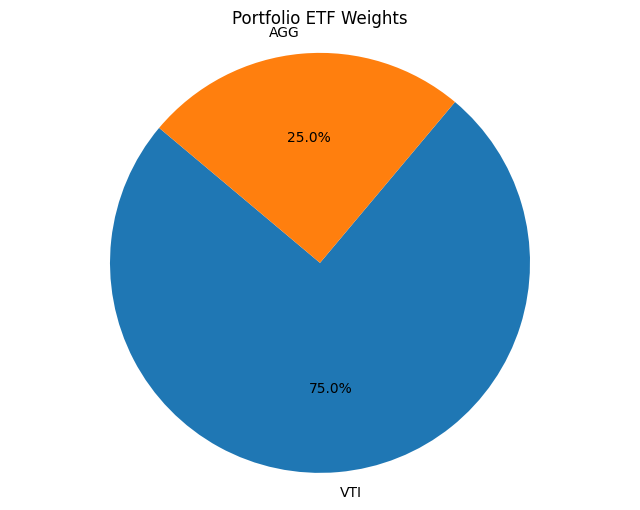

In [47]:
plt.figure(figsize=(8, 6))
plt.pie(df['Total Weight in Portfolio (%)'], labels = df['ETF'], autopct = '%1.1f%%', startangle = 140)
plt.title('Portfolio ETF Weights')
plt.axis('equal') 
plt.show()

##### Information on the ETFs in the portfolio

In [48]:
# Function to find ETF info in bond or stock ETFs
def find_etf_info1(etf_symbol, etf_data):
    # Search in bond ETFs
    for etf in etf_data.get('bond_etfs', []):
        if etf['symbol'] == etf_symbol:
            return etf

    # Search in stock ETFs
    for etf in etf_data.get('stock_etfs', []):
        if etf['symbol'] == etf_symbol:
            return etf
        
    # Search in others ETFs 
    for etf in etf_data.get('stock_etfs', []):
        if etf['symbol'] == etf_symbol:
            return etf

    return None

# Loop through each ETF in df['ETF'] and display information
for etf in df['ETF']:
    etf_info = find_etf_info1(etf, etf_classified_data)  
    if etf_info:
        print(f"Information for {etf}:")
        print(json.dumps(etf_info, indent=4))
    else:
        print(f"No information found for ETF: {etf}")


Information for VTI:
{
    "symbol": "VTI",
    "fund_holding_info": {
        "bondPosition": {
            "VTI": 0.0
        },
        "bondHoldings": {
            "VTI": {}
        },
        "bondRatings": {
            "VTI": [
                {
                    "us_government": 0.0
                }
            ]
        },
        "cashPosition": {
            "VTI": 0.0038
        },
        "sectorWeightings": {
            "VTI": [
                {
                    "realestate": 0.025
                },
                {
                    "consumer_cyclical": 0.1062
                },
                {
                    "basic_materials": 0.0188
                },
                {
                    "consumer_defensive": 0.0498
                },
                {
                    "technology": 0.3312
                },
                {
                    "communication_services": 0.0934
                },
                {
                    "financial_

##### Weighted breakdown of Investment

In [49]:
# Function to find ETF info in bond or stock ETFs
def find_etf_info(etf_symbol, etf_data):
    # Search in bond ETFs
    for etf in etf_data.get('bond_etfs', []):
        if etf['symbol'] == etf_symbol:
            return etf

    # Search in stock ETFs
    for etf in etf_data.get('stock_etfs', []):
        if etf['symbol'] == etf_symbol:
            return etf

    return None

# Initialize empty lists to store intermediate results
bond_weights_list = []
stock_weights_list = []

# Iterate through each ETF in the DataFrame
for index, row in df.iterrows():
    etf_symbol = row['ETF']
    total_weight = row['Weight in Category (%)']
    
    # Retrieve ETF info from classified data
    etf_info = find_etf_info(etf_symbol, etf_classified_data)

    if row['Category'] == 'Bonds' and etf_info:
        # Extract bond ratings list for the specific ETF
        bond_ratings_dict = etf_info.get('fund_holding_info', {}).get('bondRatings', {})
        bond_ratings = bond_ratings_dict.get(etf_symbol, []) 
        
        # Initialize a dictionary with the ETF symbol
        weighted_bonds = {'ETF': etf_symbol}
        
        # Iterate through each rating dictionary and calculate weighted values
        for rating in bond_ratings:
            if isinstance(rating, dict):
                key, value = next(iter(rating.items()))
                weighted_bonds[key] = round(total_weight * value, 3)
        
        # Append the weighted bonds dictionary to the list
        bond_weights_list.append(weighted_bonds)
    
    elif row['Category'] == 'Stocks' and etf_info:
        # Extract sector weightings list for the specific ETF
        sector_weightings_dict = etf_info.get('fund_holding_info', {}).get('sectorWeightings', {})
        sector_weightings = sector_weightings_dict.get(etf_symbol, []) 
        
        # Initialize a dictionary with the ETF symbol
        weighted_sectors = {'ETF': etf_symbol}
        
        # Iterate through each sector weighting dictionary and calculate weighted values
        for sector_weighting in sector_weightings:
            if isinstance(sector_weighting, dict):
                key, value = next(iter(sector_weighting.items()))
                weighted_sectors[key] = round(total_weight * value, 3)
        
        # Append the weighted sectors dictionary to the list
        stock_weights_list.append(weighted_sectors)

# Convert the lists into DataFrames and fill missing values with 0
bond_weights = pd.DataFrame(bond_weights_list).fillna(0)
stock_weights = pd.DataFrame(stock_weights_list).fillna(0)

# Reorder columns to have 'ETF' first
bond_columns = ['ETF'] + [col for col in bond_weights.columns if col != 'ETF']
bond_weights = bond_weights[bond_columns]

stock_columns = ['ETF'] + [col for col in stock_weights.columns if col != 'ETF']
stock_weights = stock_weights[stock_columns]

# Calculate column sums for bond and stock weights
bond_weights_sum = bond_weights.drop(columns=['ETF']).sum(numeric_only=True).round(2)
stock_weights_sum = stock_weights.drop(columns=['ETF']).sum(numeric_only=True).round(2)

# Display the results
print("\nBond Weights:")
display(bond_weights)

print("\nColumn Sum of Bond Weights:")
print(bond_weights_sum)

print("\nStock Weights:")
display(stock_weights)

print("\nColumn Sum of Stock Weights:")
print(stock_weights_sum)



Bond Weights:


,ETF,bb,aa,aaa,a,other,b,bbb,below_b,us_government
0,AGG,0.0,73.71,2.41,11.85,0.0,0.0,12.03,0.0,48.14



Column Sum of Bond Weights:
bb                0.00
aa               73.71
aaa               2.41
a                11.85
other             0.00
b                 0.00
bbb              12.03
below_b           0.00
us_government    48.14
dtype: float64

Stock Weights:


,ETF,realestate,consumer_cyclical,basic_materials,consumer_defensive,technology,communication_services,financial_services,utilities,industrials,energy,healthcare
0,VTI,2.5,10.62,1.88,4.98,33.12,9.34,13.67,2.39,9.18,3.12,9.21



Column Sum of Stock Weights:
realestate                 2.50
consumer_cyclical         10.62
basic_materials            1.88
consumer_defensive         4.98
technology                33.12
communication_services     9.34
financial_services        13.67
utilities                  2.39
industrials                9.18
energy                     3.12
healthcare                 9.21
dtype: float64


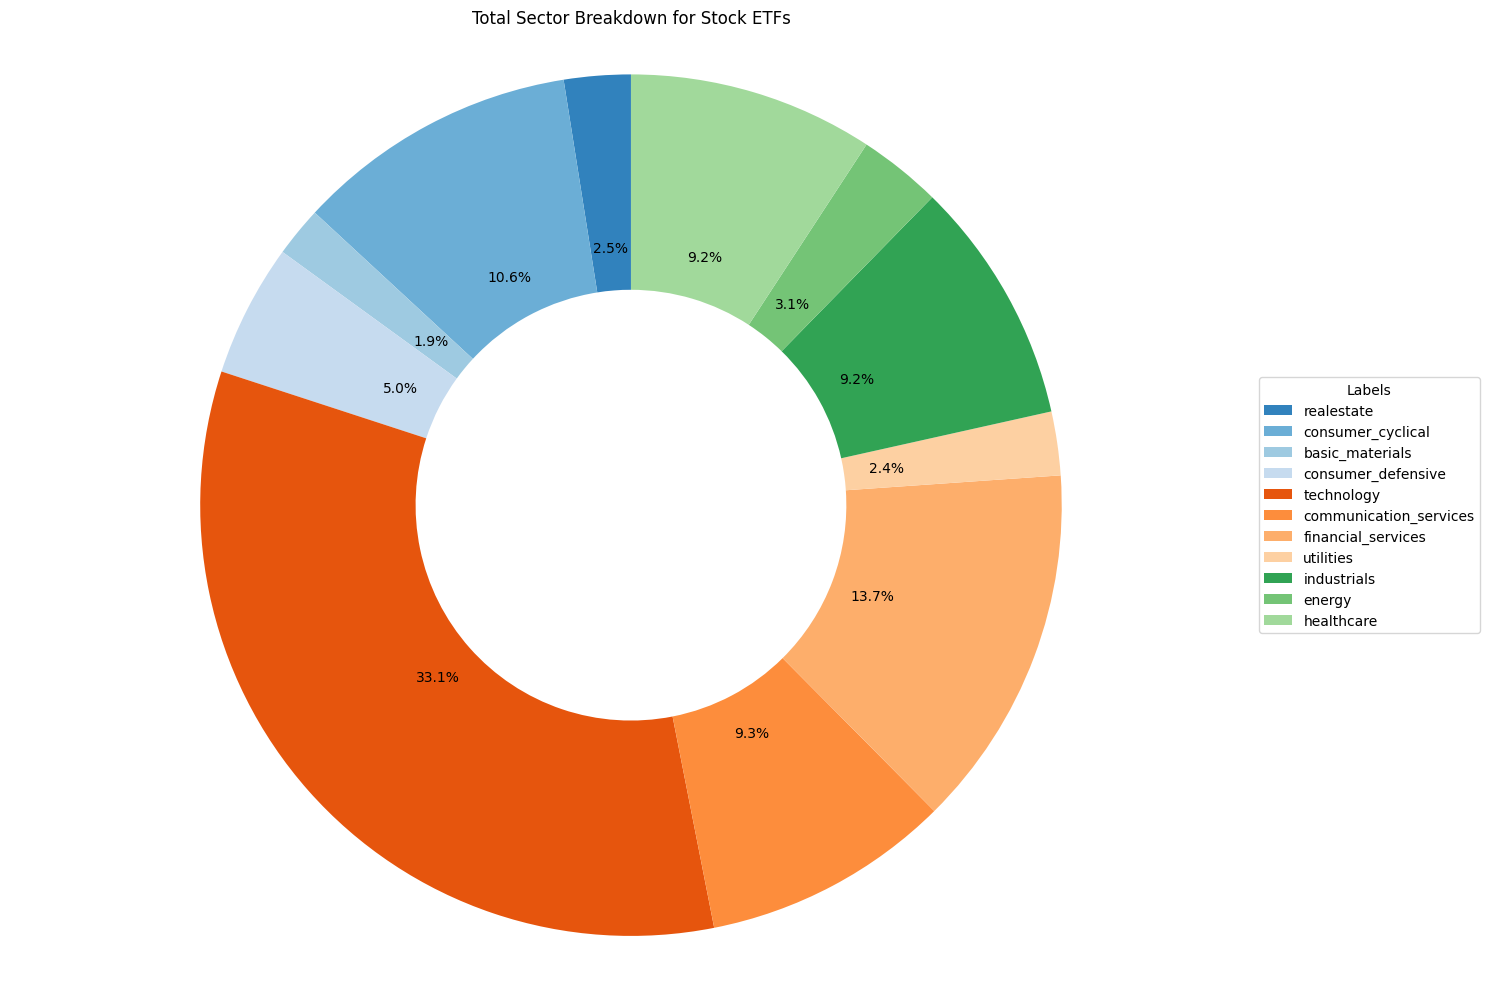

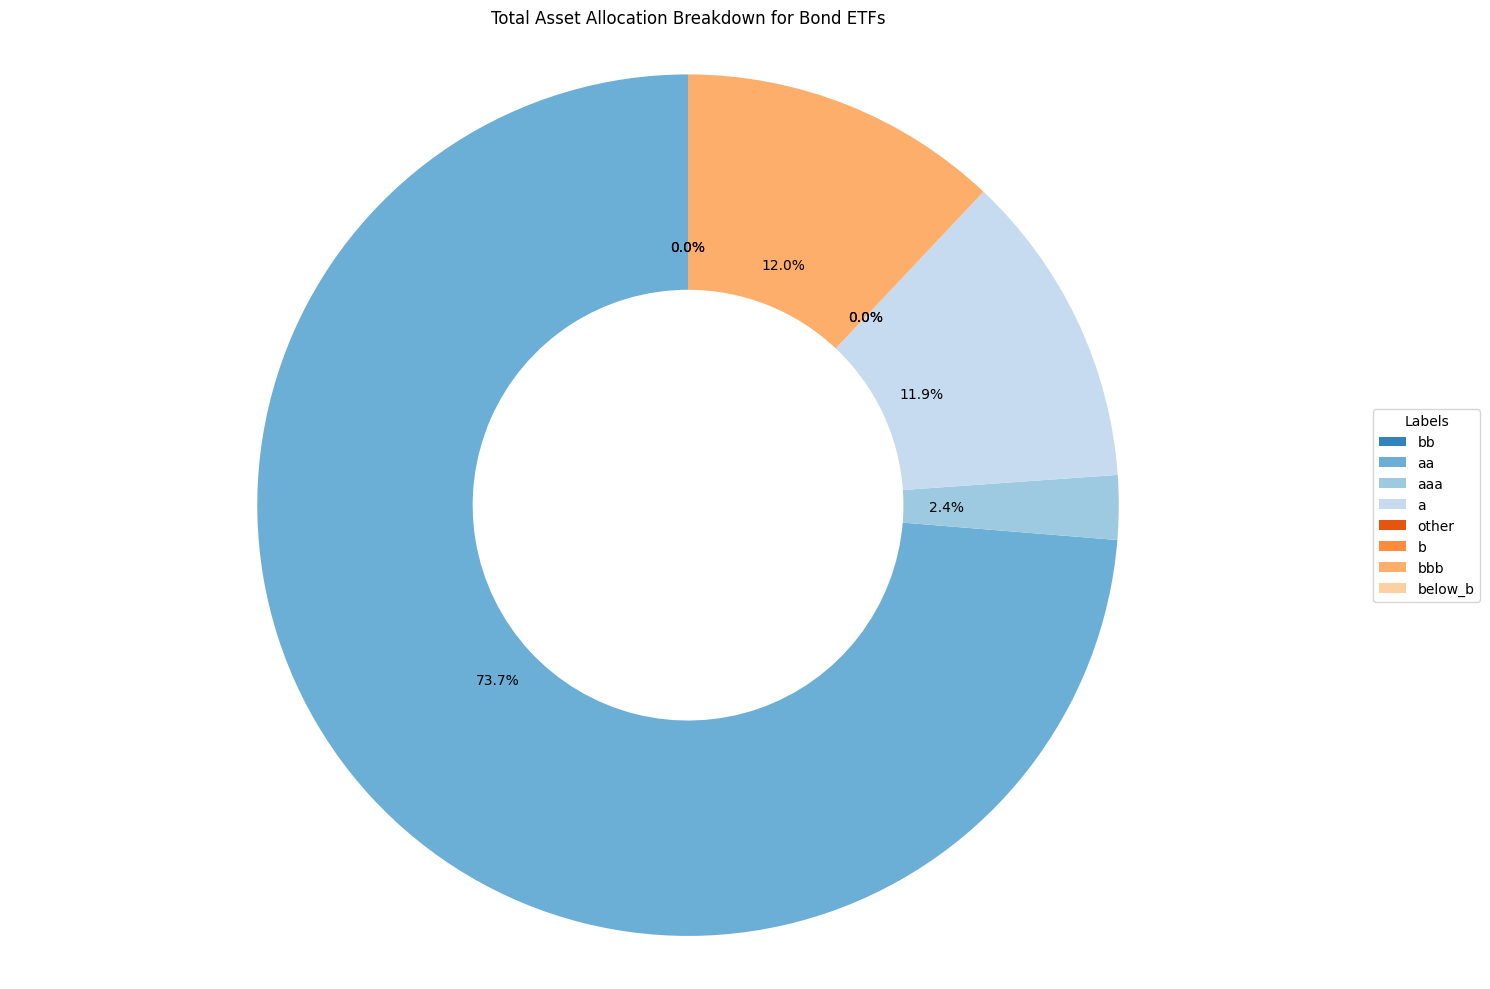

In [51]:
custom_colors = plt.cm.tab20c(np.arange(len(data)))

def plot_doughnut_chart(data, title, filename):
    labels = data.index
    sizes = data.values

    fig, ax = plt.subplots(figsize=(15,10))
    wedges, texts, autotexts = ax.pie(sizes, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5), colors=custom_colors)
    ax.axis('equal')

    # Add legend to the right side
    ax.legend(wedges, labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, format='pdf')
    plt.show()

# Plot doughnut chart for total stock ETFs sector breakdown and save it
plot_doughnut_chart(stock_weights_sum, 'Total Sector Breakdown for Stock ETFs', 'stock_etf_sector_breakdown')

# Plot doughnut chart for total bond ETFs Asset allocation breakdown and save it
plot_doughnut_chart(bond_weights.drop(columns = ['ETF', "us_government" ]).sum(numeric_only=True).round(2), 'Total Asset Allocation Breakdown for Bond ETFs', 'bond_etf_asset_allocation_breakdown')


##### Sharp Ratio

In [ ]:
from datetime import datetime, timedelta
import pandas_datareader.data as web

# Function to calculate Sharpe Ratio

def calculate_sharpe_ratio(portfolio_returns, risk_free_rate, portfolio_std_deviation):
    avg_return = np.mean(portfolio_returns)
    sharpe_ratio = (avg_return - risk_free_rate) / portfolio_std_deviation
    return sharpe_ratio

# Function to get risk-free rate from FRED

def get_risk_free_rate(symbol, start_date, end_date):
    risk_free_rate_data = web.DataReader(symbol, 'fred', start=start_date, end=end_date)
    # Use the last available value and convert to decimal
    risk_free_rate = risk_free_rate_data.iloc[-1, 0] / 100
    return risk_free_rate


# Define your portfolio and weights
portfolio = df['ETF'].tolist()  # List of ETF tickers
weights = df.set_index('ETF')['Total Weight in Portfolio (%)'].to_dict()  # Dictionary of weights

# Define time periods and corresponding risk-free rate symbols
time_periods = [365, 182, 90]  # in days
risk_free_rate_symbols = ['DGS1', 'DGS6MO', 'DGS3MO']  # FRED symbols

# Prepare dates
end_date_dt = datetime.today()

# Initialize results storage
results = []

# Loop through each time period
for days, symbol in zip(time_periods, risk_free_rate_symbols):
    start_date_dt = end_date_dt - timedelta(days=days)
    start_date = start_date_dt.strftime('%Y-%m-%d')
    end_date = end_date_dt.strftime('%Y-%m-%d')
    # Store annualized returns and standard deviations
    annualize_asset_return = []
    std_deviation_list = []
    etf_weights = []
    returns_dict = {}
    correlation_matrix = pd.DataFrame(index=portfolio, columns=portfolio)
    # Loop through each ETF
    for etf in portfolio:
        # Download ETF data
        data_raw = yf.download(etf, start=start_date, end=end_date_dt)
        
        # Flatten MultiIndex columns if necessary
        if isinstance(data_raw.columns, pd.MultiIndex):
            data_raw.columns = data_raw.columns.get_level_values(0)
        
        # Use 'Close' column
        data = data_raw['Close']
        
        # Calculate returns
        start_price = data.iloc[0]
        end_price = data.iloc[-1]
        asset_return = (end_price - start_price) / start_price
        weighted_returns = asset_return * weights[etf] / 100
        annualize_return = ((1 + weighted_returns) ** (365 / days)) - 1
        annualize_asset_return.append(annualize_return)
        
        # Daily returns for std deviation & correlation
        returns = data.pct_change().dropna()
        std_deviation = returns.std()
        std_deviation_list.append(std_deviation)
        etf_weights.append(weights[etf] / 100)
        returns_dict[etf] = returns

    # Portfolio annualized return
    annualized_portfolio_returns = np.sum(annualize_asset_return, axis=0)
    # Calculate correlation matrix
    for i in range(len(portfolio)):
        for j in range(i + 1, len(portfolio)):
            etf1 = portfolio[i]
            etf2 = portfolio[j]
            correlation = returns_dict[etf1].corr(returns_dict[etf2])
            correlation_matrix.loc[etf1, etf2] = correlation
            correlation_matrix.loc[etf2, etf1] = correlation

    correlation_matrix = correlation_matrix.fillna(1)
    correlation_matrix_np = correlation_matrix.to_numpy().astype(float)
    # Calculate portfolio standard deviation
    portfolio_std_dev = np.sqrt(
        sum(etf_weights[i] ** 2 * std_deviation_list[i] ** 2 for i in range(len(etf_weights))) +
        sum(2 * etf_weights[i] * etf_weights[j] * std_deviation_list[i] * std_deviation_list[j] * correlation_matrix_np[i, j]
            for i in range(len(etf_weights)) for j in range(i + 1, len(etf_weights)))
    )
    annualize_Portfolio_Std = portfolio_std_dev * np.sqrt(len(data))  # annualized

    # Fetch risk-free rate and calculate Sharpe ratio
    risk_free_rate = get_risk_free_rate(symbol, start_date, end_date)
    sharpe_ratio = calculate_sharpe_ratio(annualized_portfolio_returns, risk_free_rate, annualize_Portfolio_Std)

    # Append results
    results.append([
        days,
        symbol,
        round(annualized_portfolio_returns, 3),
        round(risk_free_rate, 4),
        round(annualize_Portfolio_Std, 3),
        round(sharpe_ratio, 2)])

# Convert results to DataFrame
results_df = pd.DataFrame(
    results,
    columns=['Period (Days)', 'Risk-Free Rate Symbol', 'Annualized Portfolio Return', 
             'Risk-Free Rate', 'Annualized Portfolio Std Dev', 'Sharpe Ratio'])

results_df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Period (Days),Risk-Free Rate Symbol,Annualized Portfolio Return,Risk-Free Rate,Annualized Portfolio Std Dev,Sharpe Ratio
0,365,DGS1,0.141,0.0361,0.147,0.71
1,182,DGS6MO,0.282,0.0381,0.126,1.94
2,90,DGS3MO,0.363,0.0403,0.035,9.17


##### Tyrenor Ratio :  treynor_ratio = (rp - rf) / beta_p

In [58]:

# Function to calculate Treynor Ratio
def calculate_Treynor_ratio(portfolio_returns, risk_free_rate, portfolio_beta):
    avg_return = np.mean(portfolio_returns)
    treynor_ratio = (avg_return - risk_free_rate) / portfolio_beta
    return treynor_ratio



results = []

# Loop through time periods
for days, symbol in zip(time_periods, risk_free_rate_symbols):
    start_date_dt = end_date_dt - timedelta(days=days)
    start_date = start_date_dt.strftime('%Y-%m-%d')
    end_date = end_date_dt.strftime('%Y-%m-%d')

    annualize_asset_return = []
    beta_list = []
    etf_weights = []

    # Download benchmark returns
    bond_benchmark_raw = yf.download('AGG', start=start_date, end=end_date_dt)
    if isinstance(bond_benchmark_raw.columns, pd.MultiIndex):
        bond_benchmark_raw.columns = bond_benchmark_raw.columns.get_level_values(0)
    bond_benchmark_return = bond_benchmark_raw['Close'].pct_change().dropna()

    stock_benchmark_raw = yf.download('^GSPC', start=start_date, end=end_date_dt)
    if isinstance(stock_benchmark_raw.columns, pd.MultiIndex):
        stock_benchmark_raw.columns = stock_benchmark_raw.columns.get_level_values(0)
    stock_benchmark_return = stock_benchmark_raw['Close'].pct_change().dropna()

    Bond_in_Portfolio = df[df['Category'] == 'Bonds']

    # ----------------------------
    # Loop through each ETF
    # ----------------------------
    for etf in portfolio:
        data_raw = yf.download(etf, start=start_date, end=end_date_dt)
        if isinstance(data_raw.columns, pd.MultiIndex):
            data_raw.columns = data_raw.columns.get_level_values(0)
        data = data_raw['Close']

        # Asset return
        start_price = data.iloc[0]
        end_price = data.iloc[-1]
        asset_return = (end_price - start_price) / start_price
        weighted_returns = asset_return * weights[etf] / 100
        annualize_return = ((1 + weighted_returns) ** (365 / days)) - 1
        annualize_asset_return.append(annualize_return)

        # Beta calculation
        returns = data.pct_change().dropna()
        if etf in Bond_in_Portfolio['ETF'].values:
            benchmark_returns = bond_benchmark_return
        else:
            benchmark_returns = stock_benchmark_return

        # Simple beta formula: cov(asset, benchmark) / var(benchmark)
        cov_matrix = np.cov(returns, benchmark_returns)
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]
        beta_list.append(beta)
        etf_weights.append(weights[etf] / 100)

    # ----------------------------
    # Portfolio metrics
    # ----------------------------
    annualized_portfolio_returns = np.sum(annualize_asset_return, axis=0)
    risk_free_rate = get_risk_free_rate(symbol, start_date, end_date)
    portfolio_beta = sum(etf_weights[i] * beta_list[i] for i in range(len(etf_weights)))
    treynor_ratio = calculate_Treynor_ratio(annualized_portfolio_returns, risk_free_rate, portfolio_beta)

    results.append([
        days,
        symbol,
        round(annualized_portfolio_returns, 3),
        round(risk_free_rate, 4),
        round(portfolio_beta, 3),
        round(treynor_ratio, 4)
    ])

# ----------------------------
# Convert results to DataFrame
# ----------------------------
results_df = pd.DataFrame(
    results,
    columns=['Period (Days)', 'Risk-Free Rate Symbol', 'Annualized Portfolio Return',
             'Risk-Free Rate', 'Portfolio Beta', 'Treynor Ratio']
)

results_df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Period (Days),Risk-Free Rate Symbol,Annualized Portfolio Return,Risk-Free Rate,Portfolio Beta,Treynor Ratio
0,365,DGS1,0.141,0.0361,1.026,0.1024
1,182,DGS6MO,0.282,0.0381,1.031,0.2366
2,90,DGS3MO,0.363,0.0403,1.031,0.3131
